# Load packages

In [ ]:
!pip install -r http://users.uoa.gr/~nalygizakis/Applied%20Data%20Science/requirements.txt

     |████████████████████████████████| 285 kB 5.1 MB/s 
     |████████████████████████████████| 303 kB 55.7 MB/s 
     |████████████████████████████████| 204 kB 43.2 MB/s 
     |████████████████████████████████| 22.3 MB 1.8 MB/s 
     |████████████████████████████████| 43 kB 1.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pingouin: filename=pingouin-0.3.11-py3-none-any.whl size=203793 sha256=d3814807f5e475fe603924a14b1729d04814849fdbd1d0a79a271e6905394a9f
  Stored in directory: /root/.cache/pip/wheels/74/6d/d2/9320ff7695f6983f4394c10630792f4bd4c8351facfd39b649
  Created wheel for scikit-posthocs: filename=scikit_posthocs-0.6.7-py3-none-any.whl size=37902 sha256=e1892957a99bfa8b7529d3e6cf6b0a697dc0a9e12948940ffe989a0210e6e451
  Stored in directory: /root/.cache/pip/wheels/b8/21/e6/f39794d4a6ee3d3cc5146ca80b5cd949452ad4a8fde9f6b9fc
  Created wheel for littleutils: filename=littleu

In [ ]:
from time import time
from collections import Counter

import graphviz
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz

from joblib import dump, load
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.feature_selection import SelectFromModel, VarianceThreshold, RFECV, SequentialFeatureSelector
from sklearn.model_selection import GridSearchCV, KFold, RepeatedKFold, cross_validate, train_test_split, validation_curve
from sklearn.metrics import multilabel_confusion_matrix, classification_report, roc_curve, auc, accuracy_score, hamming_loss, make_scorer

import pingouin as pg
import scikit_posthocs as sp
from mlxtend.evaluate import mcnemar
from mlxtend.evaluate import mcnemar_table

sns.set()
import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load some helper functions

In [ ]:
def qconstant_filtering(X, thresh=0.01):
  '''Remove constant and quasi-constant features.'''

  qconstant_filter = VarianceThreshold()
  qconstant_filter.fit(X)

  qfeatures = X.iloc[:, qconstant_filter.variances_ <= thresh].columns

  print(f"Quasi-Constant features found: {len(qfeatures)}")

  X = X.drop(labels=qfeatures, axis=1)

  print(f"New feature shape: {X.shape}")
  return X


def correlation_filtering(X, thresh=0.9, method='spearman'):
    '''Remove correlated features.'''

    # Set of all the names of deleted columns
    col_corr = set()

    # Create correlation matrix from the dataset
    corr_matrix = X.corr(method=method).abs()

    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= thresh) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in X.columns:
                    del X[colname] # deleting the column from the dataset

    print(f"Correlated features found: {len(col_corr)}")
    print(f"New feature shape: {X.shape}")
    return X

def feature_importance(model, X, Y, thresh='1.5*mean'):
    '''Select features based on importance weights.'''

    # Initialize and apply transformer
    forest_sel = SelectFromModel(model, threshold=thresh)

    tic = time()

    forest_sel.fit(X, Y)

    toc = time()

    # Transform X feature set
    X = X.iloc[:, forest_sel.get_support()]

    print(f"Done in {(toc - tic)/60:0.2f} minutes")
    print(f"New feature shape: {X.shape}")
    return X

def rfecv_selection(model, X, Y, cv=10, scoring=None, figure=False):
    '''Feature ranking with recursive feature elimination and
    cross-validated selection of the best number of features.'''

    # Initialize and apply RFECV
    rfecv = RFECV(estimator=model, step=1, cv=cv, scoring=scoring, n_jobs=-1)

    tic = time()

    rfecv.fit(X, Y)

    toc = time()

    # Transform X feature set
    X = X.iloc[:, rfecv.support_]

    print(f"Done in {(toc - tic)/60:0.2f} minutes")
    print(f"Optimal number of features: {rfecv.n_features_}")
    print(f"New feature shape: {X.shape}")

    # Plot RFECV search
    if figure == True:

        # Plot number of features VS. cross-validation scores
        plt.figure(figsize=(16,9))


        plt.xticks(np.arange(0, 56, 5).astype(int))
        plt.xlabel("Number of features selected", fontsize=15)
        plt.ylabel("Cross validation score (Accuracy)", fontsize=15)
        plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)

        plt.savefig('RFECV.png')
        plt.show()

    return X

def forward_selection(model, X, Y, cv=10, n_feat=10, scoring=None, feat_only=False):
    '''Perform Sequential Feature Selection in the forward direction.'''

    # Initialize and apply Sequential Forward selection
    sfs_forward = SequentialFeatureSelector(model, n_features_to_select=n_feat, cv=cv,
                                            direction='forward', scoring=scoring, n_jobs=-1)

    tic = time()

    sfs_forward.fit(X, Y)

    toc = time()

    # Transform X and get feature set
    X = X.iloc[:, sfs_forward.get_support()]
    features = X.columns.to_list()

    print(f"Done in {(toc - tic)/60:0.2f} minutes")

    if feat_only == True:
        return features

    print(f"New feature shape: {X.shape}")
    print(f"Features selected by sequential forward selection: {features}")
    return X

def manual_selection(features, thresh=0.5):
    '''Manually select robust features by calculating overlap.'''

    # Calculate feature overlap
    count_overlap = Counter(x for xs in features for x in set(xs))

    # Initialize list to collect features
    sel_feat = []
    start = len(features)
    stop = int(len(features)*thresh)


    for i in range(start, stop, -1):
        for k, v in count_overlap.items():
            if v == i and len(sel_feat) < 10:
                sel_feat.append(k)

    print(f'Selected features with good overlap: {sel_feat}')

    return sel_feat

In [ ]:
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''Compute the Hamming score (i.e., label-based accuracy) for the multi-label case.'''

    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        acc_list.append(tmp_a)
    return np.mean(acc_list)

def model_comparison(models, X, Y, cv=10, scoring=None):
    '''Model comparison using dictionary with different pipelines.'''

    # Initialize lists to store results
    names = []
    results = []

    # k-fold CV results
    for key, value in models.items():
        cv_results = cross_validate(value['pl'], X, Y, cv=cv, scoring = scoring, n_jobs=4)
        results.append(cv_results)
        names.append(value['name'])

        if scoring:
            print(f"\n{value['name']:<11}: Exact Match Ratio =    {cv_results['test_Exact Match Ratio'].mean():0.3f} ({cv_results['test_Exact Match Ratio'].std():0.3f})")
            print(f"{' ':<11}  Label-based Accuracy = {cv_results['test_Label-based Accuracy'].mean():0.3f} ({cv_results['test_Label-based Accuracy'].std():0.3f})")
        else:
            print(f"{value['name']:<11}: {cv_results['test_score'].mean():0.3f} ({cv_results['test_score'].std():0.3f})")

    return results, names

def feature_comparison(model, X, Y, cv=10, scoring=None, X_names=None, save=True):
    '''Perform cross-validation using the same classifier with different feature sets.'''

    # Initialize dataframe to store results
    ds_result = pd.DataFrame()

    # Perform cross-validation and save the results
    if X_names:
        for name, data in zip(X_names, X):
            cv_results = cross_validate(model, data, Y, cv=cv, scoring=scoring, n_jobs=4)
            ds_result[name] = cv_results['test_score']
    else:
        for idx, data in enumerate(X):
            cv_results = cross_validate(model, data, Y, cv=cv, scoring=scoring, n_jobs=4)
            ds_result[idx] = cv_results['test_score']

    if save == True:
        ds_result.to_csv('Performance of different feature sets in CV.csv', index=None)

    return ds_result

def accuracy_per_class(y_true, y_pred):
    '''Calculate accuracy per class.'''

    # Compute confusion matrix for the multilabel case
    cm = multilabel_confusion_matrix(y_true, y_pred)

    # Calculate accuracy for each label (TP + TN)/(TP + FP + TN + FN)
    gc_acc = cm[0].diagonal().sum()/cm[0].sum()
    lc_acc = cm[1].diagonal().sum()/cm[1].sum()

    return (gc_acc, lc_acc)

def general_classification_report(y_true, y_pred, title='Classification Report'):
    '''Show a Classification Report with accuracy.'''

    print(title)
    print('-'*len(title))
    print(classification_report(y_true, y_pred, zero_division=0))

    print("\nAccuracy per class")
    print(f'GC = {accuracy_per_class(y_true, y_pred)[0]:0.3f}')
    print(f'LC = {accuracy_per_class(y_true, y_pred)[1]:0.3f}')

    print(f'\nLabel-based accuracy = {hamming_score(y_true, y_pred):0.3f}')

    return classification_report(y_true, y_pred, zero_division=0, output_dict=True)

def show_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):
    '''Calculate and plot confusion matrix.'''

    # Plot heatmap from confusion matrix
    ds_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)

    try:
        heatmap = sns.heatmap(ds_cm, annot=True, fmt="d", cbar=False, ax=axes, cmap='Blues')
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the " + class_label + " class", fontsize=14)

def plot_roc_curve(y_true, y_pred1, y_pred2, model_names, class_names=None, title='ROC curve', save=False):
    '''Calculate and plot ROC curve.'''

    # Get number of classes/labels
    n_classes = y_true.shape[1]

    # Compute ROC curve and ROC area for each class
    fpr, tpr, roc_auc = dict(), dict(), dict()

    for i in range(0, n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred1[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    for i in range(n_classes, 2*n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i-n_classes], y_pred2[:, i-n_classes])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(12, 8))

    if class_names:
        for i in range(0, 2*n_classes):
          plt.plot(fpr[i], tpr[i], lw=2,
                    label=f'{model_names[i]}: {class_names[i%2]} class (AUC = {roc_auc[i]:0.3f})')
    else:
        for i in range(2*n_classes):
            plt.plot(fpr[i], tpr[i], lw=2,
                     label=f'{model_names[i]}: Class {i%2} (AUC = {roc_auc[i]:0.3f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='best')

    if save:
        plt.savefig(title + '.png')

    plt.show()

In [ ]:
def tree_optimization(model, param_grid, X, Y, cv=10, scoring=None):
    '''Optimize Decision Tree Classifier using Grid Search.'''

    # Initialize and apply GridSearchCV
    grid_cv = GridSearchCV(model, param_grid, cv=cv, verbose=1, n_jobs=-1, scoring=scoring)

    tic = time()

    grid_cv.fit(X, Y)

    toc = time()

    print(f"Done in {(toc - tic)/60:0.2f} minutes")
    print(f"Best estimator: {grid_cv.best_estimator_} with score {grid_cv.best_score_}")

    return grid_cv.best_estimator_

def plot_validation_curve(estimator, X, y, param_name, param_range = np.arange(1, 30), ylim=(0.0, 1.1), cv=10, scoring='accuracy', save=False):
    '''Generate a plot of the validation curve for a given hyperparameter.'''

    # Calculate scores
    train_scores, test_scores = validation_curve(
                                estimator, X, y, param_name=param_name, cv=cv, 
                                param_range=param_range,
                                scoring=scoring)

    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis = 1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plotting options
    plt.figure(figsize=(18, 9))
    plt.xlabel(param_name, fontsize=15)
    plt.xticks(param_range, fontsize=13)
    plt.yticks(np.arange(0, 1.1, 0.1), fontsize=13)
    plt.ylabel("Hamming Score", fontsize=15)
    plt.ylim(*ylim)

    plt.plot(param_range, train_scores_mean, label="Training score", color="r")
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=2)
    plt.plot(param_range, test_scores_mean, label="Test score", color="g")
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=2)
    plt.legend(loc="best", fontsize=15)

    if save == True:
        plt.savefig('Decision Tree Validation Curve (max_depth).png')

    return plt

In [ ]:
def friedman_test(dataset, alpha=0.05, long=False, effect_size=True):
    '''Perform the Friedman test on a provided dataset.'''

    # Transform dataframe to the appropriate format
    if not long:
        dataset = dataset.melt(ignore_index=False).reset_index(drop=False)
        dataset = dataset.rename(columns={'index': 'Fold', 'variable': 'Feature set', 'value': 'Accuracy'})

    # Perform the Friedman test
    result = pg.friedman(dataset, dv='Accuracy', within='Fold', subject='Feature set')

    fried, p_value = result['Q'][0], result['p-unc'][0]

    print(f'Friedman statistic: {fried:0.2f}')
    print(f'p-value: {p_value:0.6f}')

    if p_value < alpha:
        print('\nThe differences between some of the groups are statistically significant.')
        print('Use a post hoc test to determine which classifiers actually differ.')
    else:
        print('\nThe differences between the groups are not statistically significant.')

    # Calculate effect size
    if effect_size == True:
        print('\nRelevant effect size')
        print('----------------------')
        print(f"Kendall's W coefficient: {result['W'][0]:0.3f}")

    return result

def nemeyi_test(dataset, alpha=0.05, significant_only=False):
    '''Perform the Nemeyi Post Hoc test on a provided dataset.'''

    # Perform the Nemenyi test
    ds_nemeyi = sp.posthoc_nemenyi_friedman(dataset)

    if significant_only == True:
        print(f'Returning only statistically significant differences (p value < {alpha})')

        return ds_nemeyi[ds_nemeyi < alpha]

    return ds_nemeyi

def wilcoxon_test(x, y, alpha=0.05, alternative='two-sided', effect_size=True):
    '''Perform the Wilcoxon-Signed Rank test on two sets of observations.'''

    # Perform the Wilcoxon Test
    result = pg.wilcoxon(x, y, tail=alternative)

    wilcoxon, p_value = result['W-val'][0], result['p-val'][0]

    print(f'Wilcoxon statistic: {wilcoxon:0.2f}')
    print(f'p-value: {p_value:0.6f}')

    if p_value < alpha:
        print('\nThe differences between measurements are statistically significant.')
    else:
        print('\nThe differences between measurements are not statistically significant.')

    # Calculate effect size
    if effect_size == True:
        print('\nRelevant effect sizes')
        print('-----------------------')
        print(f"Rank-biserial correlation: {result['RBC'][0]:0.3f}")
        print(f"Common language effect size: {result['CLES'][0]:0.3f}")

    return result

def mcnemar_test(y_true, y_pred1, y_pred2, visualize=True, save=True, title="McNemar's table", model_names=None, effect_size=True):
    '''Calculate McNemar's test to compare two classifiers.'''

    # Compute 2x2 contingency table
    table = mcnemar_table(y_true, y_pred1, y_pred2)

    # Plot 2x2 contingency table
    if visualize == True:
        if model_names:
            col_labels=['Rule-based Classifier Correct', 'Rule-based Classifier Incorrect']
            row_labels=['Decision Tree Classifier Correct', 'Decision Tree Classifier Incorrect']
        else:
            col_labels=['Model 1 Correct', 'Model 1 Incorrect']
            row_labels=['Model 2 Correct', 'Model 2 Incorrect']

        plt.figure(figsize=(12, 9))

        ds_table = pd.DataFrame(table, index=row_labels, columns=col_labels)

        heatmap = sns.heatmap(ds_table, annot=True, fmt="d", cbar=False, cmap='Blues')

        plt.yticks([0.2, 1.15])

        plt.title(title)

        if save == True:
            plt.savefig(title + '.png')

    # Calculate test statistic and corresponding p-value
    chi2, p = mcnemar(table)

    print(f'Chi-squared statistic: {chi2:0.2f}')
    print(f'p-value: {p:0.6f}')

    # Calculate effect size
    if effect_size == True:

        # Calculate odds ratio (OR)
        b = table[0, 1]
        c = table[1, 0]
        OR = max(b/c, c/b)

        print('\nRelevant effect size')
        print('----------------------')
        print(f'Odds Ratio: {OR:0.2f}')

        return pd.DataFrame({'chi2': chi2, 'p-val': p, 'OR': OR}, index=['McNemar'])

    return pd.DataFrame({'chi2': chi2, 'p-val': p}, index=['McNemar'])

In [ ]:
class RulePredict:


    def __init__(self, multilabel=True, GC=None, LC=None):
        '''Initialize Rule-based Predictor.'''

        self.GC = GC
        self.LC = LC
        self.multilabel = multilabel

    def predict(self, X):
        '''Predict GC-LC class for the input X.'''

        if self.multilabel == True:
            return np.array([self.gc_predict(X), self.lc_predict(X)])

        elif self.GC == True:
            return self.gc_predict(X)

        elif self.LC == True:
            return self.lc_predict(X)

        else:
            raise ValueError('Invalid input. Choose a valid method (multilabel, GC, LC).')

    def gc_predict_proba(self, X):
        '''Predict GC class probabilities of the input samples X.'''

        prob = 0

        if 100 <= X['BoilingPoint'] <= 350:
            prob += 1/3
        if 2 <= X['logP']:
            prob += 1/3
        if X['MW'] <= 700:
            prob += 1/3

        return prob

    def gc_predict(self, X, threshold=0.5):
        '''Predict GC class value for X.'''


        prob = self.gc_predict_proba(X)

        return 1 if prob >= threshold else 0

    def lc_predict_proba(self, X):
        '''Predict LC class probabilities of the input samples X.'''

        prob = 0

        if X['logP'] <= 5.91:
            prob += 1

        return prob

    def lc_predict(self, X, threshold=0.5):
        '''Predict LC class value for X.'''

        prob = self.lc_predict_proba(X)

        return 1 if prob >= threshold else 0

In [ ]:
model_dict = \
    {
    # experiments to build pipeline
    # Note: keys are of the form model_*, which are used to execute the associated values of 'pl' keys
    'model_1': {
        'name': 'Dummy',
        'pl': Pipeline([ ('dummy_clf', DummyClassifier(strategy='stratified', random_state=42)) ])
        },
    # systematic check of default classifiers + scaling
    'model_2': {
        'name': 'KNN',
        'pl': Pipeline([ ('knn', KNeighborsClassifier(n_jobs=-1)) ])
        },
    'model_3': {
        'name': 'Scaled KNN',
        'pl': Pipeline([ ('scaling', StandardScaler()),
                        ('knn', KNeighborsClassifier(n_jobs=-1)) ])
        },
    'model_4': {
        'name': 'DT',
        'pl': Pipeline([ ('decision-tree', DecisionTreeClassifier(random_state=42)) ])
        },
    'model_5': {
        'name': 'Scaled DT',
        'pl': Pipeline([ ('scaling', StandardScaler()),
                        ('decision-tree', DecisionTreeClassifier(random_state=42)) ])
        },
    'model_6': {
        'name': 'RF',
        'pl': Pipeline([ ('random-forest', RandomForestClassifier(random_state=42, n_estimators=100)) ])
        },
    'model_7': {
        'name': 'Scaled RF',
        'pl': Pipeline([ ('scaling', StandardScaler()),
                        ('random-forest', RandomForestClassifier(random_state=42, n_estimators=100)) ])
        }
    }

# Load dataset

In [ ]:
path = 'http://users.uoa.gr/~nalygizakis/Applied%20Data%20Science/GC_LC%20dataset.xlsx'
ds = pd.read_excel(path)

In [ ]:
ds.head()

,Name,SMILES,PubChemCID,ChemSpiderID,DTXSID,List,Row,Response,Name.1,BoilingPoint,logP,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nAromBond,nAtom,nHeavyAtom,nH,nB,nC,nN,nO,nS,nP,nF,nCl,nBr,nI,nX,ATS0m,ATS1m,ATS2m,ATS3m,ATS4m,ATS5m,ATS6m,ATS7m,...,VE1_D,VE2_D,VE3_D,VR1_D,VR2_D,VR3_D,TopoPSA,VABC,VAdjMat,MWC2,MWC3,MWC4,MWC5,MWC6,MWC7,MWC8,MWC9,MWC10,TWC,SRW2,SRW3,SRW4,SRW5,SRW6,SRW7,SRW8,SRW9,SRW10,TSRW,MW,AMW,WTPT-1,WTPT-2,WTPT-3,WTPT-4,WTPT-5,WPATH,WPOL,XLogP,Zagreb
0,Metformin,CN(C)C(=N)NC(N)=N,4091,3949,DTXSID2023270,GC S70;LC S3,3936;1,GC;LC,AUTOGEN_1_1,268.97,-1.03416,0,-0.2231,0.049774,31.2928,19.874723,0,0,20,9,11,0,4,5,0,0,0,0,0,0,0,0,1569.213433,1489.142424,1918.702090,1660.618344,1354.838774,870.740052,245.119392,18.289152,...,4.650545e-02,5.167272e-03,-2.761367,3.518077e+01,3.908975,3.204450,88.99,127.451281,4.169925,3.610918,4.290459,5.068904,5.783825,6.555357,7.284135,8.049746,8.785234,9.546884,75.975462,2.833213,0.0,4.043051,0.000000,5.398163,0.000000,6.816736,0.000000,8.267962,8.538955,129.101445,6.455072,16.327527,1.814170,12.922711,0.000000,12.922711,96,8,0.558,36
1,Caffeine,CN1C(=O)N(C)c2ncn(C)c2C1(=O),2519,2424,DTXSID0020232,GC S3;LC S3,56;2,GC;LC,AUTOGEN_1_2,430.85,-1.02930,0,-0.4311,0.185847,34.8722,26.751930,5,5,24,14,10,0,8,4,2,0,0,0,0,0,0,0,2460.993806,2644.545947,4045.596023,4595.614281,3920.830055,1807.596724,541.256565,69.718320,...,9.793972e-03,6.995694e-04,-6.476383,1.141528e+02,8.153771,6.632553,58.44,162.333078,4.807355,4.343805,5.241747,6.159095,7.072422,7.991931,8.908018,9.827524,10.744473,11.663713,100.952729,3.433987,0.0,4.812184,2.397895,6.398595,4.727388,8.084254,6.842683,9.824498,10.066754,194.080376,8.086682,27.800102,1.985722,17.761592,5.042091,12.719500,258,25,-0.625,76
2,Tramadol,COC1=CC=CC(=C1)[C@@]1(O)CCCC[C@@H]1CN(C)C,33741,31105,DTXSID90858931,GC S70;LC S3,4883;3,GC;LC,AUTOGEN_1_3,355.82,2.63460,0,-0.9385,0.880782,48.7166,47.533825,6,6,44,19,25,0,16,1,2,0,0,0,0,0,0,0,3041.759587,3407.600996,4841.639644,5538.531978,5362.040452,5209.336419,4002.672643,2550.984419,...,3.410667e-02,1.795088e-03,-6.418698,1.525807e+02,8.030562,9.552618,32.70,270.347133,5.247928,4.574711,5.416100,6.304449,7.180070,8.076205,8.965079,9.863967,10.758860,11.658886,111.798326,3.713572,0.0,5.030438,0.000000,6.569481,0.000000,8.215277,0.000000,9.918425,10.123426,263.188529,5.981557,37.952373,1.997493,8.380485,5.376169,3.004316,670,30,2.881,96
3,Venlafaxine,CN(C)CC(C1=CC=C(C=C1)OC)C2(CCCCC2)O,5656,5454,DTXSID6023737,LC S3,4,LC,AUTOGEN_1_4,363.80,3.03560,0,-1.2265,1.504302,51.6282,50.627411,6,6,47,20,27,0,17,1,2,0,0,0,0,0,0,0,3188.055836,3576.079293,5035.348181,5585.453662,5505.661445,5587.717290,4535.861090,3195.301918,...,1.736753e-01,8.683764e-03,-3.501136,1.461606e+02,7.308032,9.969413,32.70,287.643117,5.321928,4.615121,5.442418,6.322565,7.181592,8.069342,8.941545,9.831830,10.710120,11.601275,113.715808,3.761200,0.0,5.068904,0.000000,6.588926,0.000000,8.206038,0.000000,9.875242,10.087932,277.204179,5.897961,39.924107,1.996205,8.362280,5.349601,3.012679,792,30,3.239,100
4,carbamazepine,c1ccc2c(c1)C=Cc3ccccc3N2C(=O)N,2554,2457,DTXSID4022731,GC S3;LC S3,115;5,GC;LC,AUTOGEN_1_5,410.02,3.38720,0,-0.1599,0.025568,20.2612,37.403516,12,12,30,18,12,0,15,2,1,0,0,0,0,0,0,0,2824.514682,3178.387104,4614.262884,5434.720145,5261.654319,4859.088099,2334.946963,730.517259,...,1.942890e-16,1.079383e-17,-65.118933,5.000075e+06,277781.962941,27.764934,46.33,218.818929,5.169925,4.574711,5.442418,6.336826,7.227662,8.128290,9.025335,9.926960,10.825979,11.727642,111.215823,3.713572,0.0,5.030438,0.000000,6.561031,2.708050,8.191186,5.379897,9.872048,10.091418,236.094963,7.869832,37.243138,2.069063,8.382014,2.444637,5.937377,521,33,4.160,96


In [ ]:
# Initial feature set
X = ds.iloc[:, 9:]

# Target variable (multilabel)
mlb = MultiLabelBinarizer()
mlb.fit([['GC', 'LC']])
y = mlb.transform(ds['Response'].str.split(';'))

print(X.shape, y.shape)

(6431, 1446) (6431, 2)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)

print(f'X_train = {X_train.shape}, Y_train = {Y_train.shape}, X_test = {X_test.shape}, Y_test = {Y_test.shape}')

X_train = (5144, 1446), Y_train = (5144, 2), X_test = (1287, 1446), Y_test = (1287, 2)


# Build the model

In [ ]:
# Initialize Decision Tree
dtree = DecisionTreeClassifier(max_depth=4, random_state=42)

# Transform Train/Test set using selected features
sel_feat = ['gmin', 'TopoPSA', 'BoilingPoint', 'BCUTc-1l', 'nN', 'nBase', 'MLFER_A', 'hmax']
X_sel = X_train[sel_feat]
X_test_sel = X_test[sel_feat]

# Train on final dataset
dtree.fit(X_sel, Y_train)

# Predict on test set
tree_pred = dtree.predict(X_test_sel)

# Save model
dump(dtree, 'DecisionTree.joblib')

title = 'Classification Report - Decision Tree Classifier'

# Evaluate
tree_report = general_classification_report(Y_test, tree_pred, title=title)

Classification Report - Decision Tree Classifier
------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       977
           1       0.76      0.96      0.85       794

   micro avg       0.79      0.92      0.85      1771
   macro avg       0.79      0.92      0.85      1771
weighted avg       0.80      0.92      0.85      1771
 samples avg       0.82      0.92      0.84      1771


Accuracy per class
GC = 0.766
LC = 0.791

Label-based accuracy = 0.779


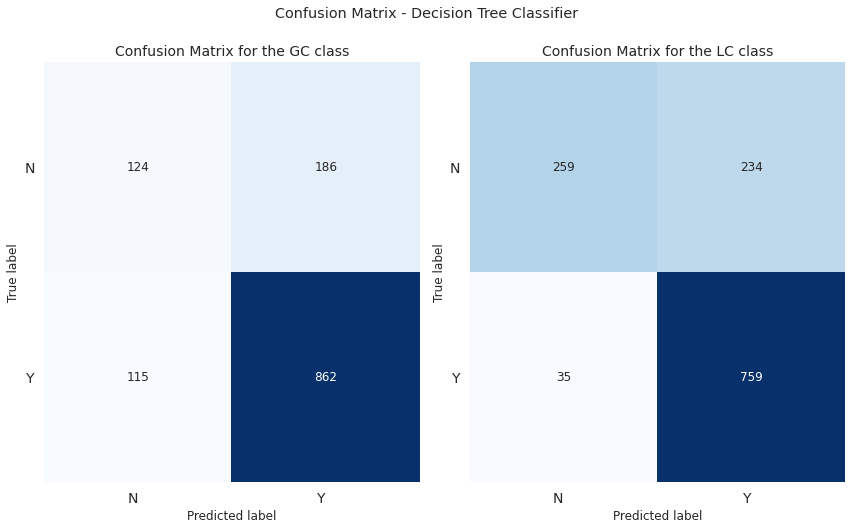

In [ ]:
cm = multilabel_confusion_matrix(Y_test, tree_pred)

fig, ax = plt.subplots(1, 2, figsize=(12, 7))

fig.suptitle('Confusion Matrix - Decision Tree Classifier', y=1.05)

show_confusion_matrix(cm[0], ax[0], 'GC', ['N', 'Y'])
show_confusion_matrix(cm[1], ax[1], 'LC', ['N', 'Y'])

fig.tight_layout()
plt.show()

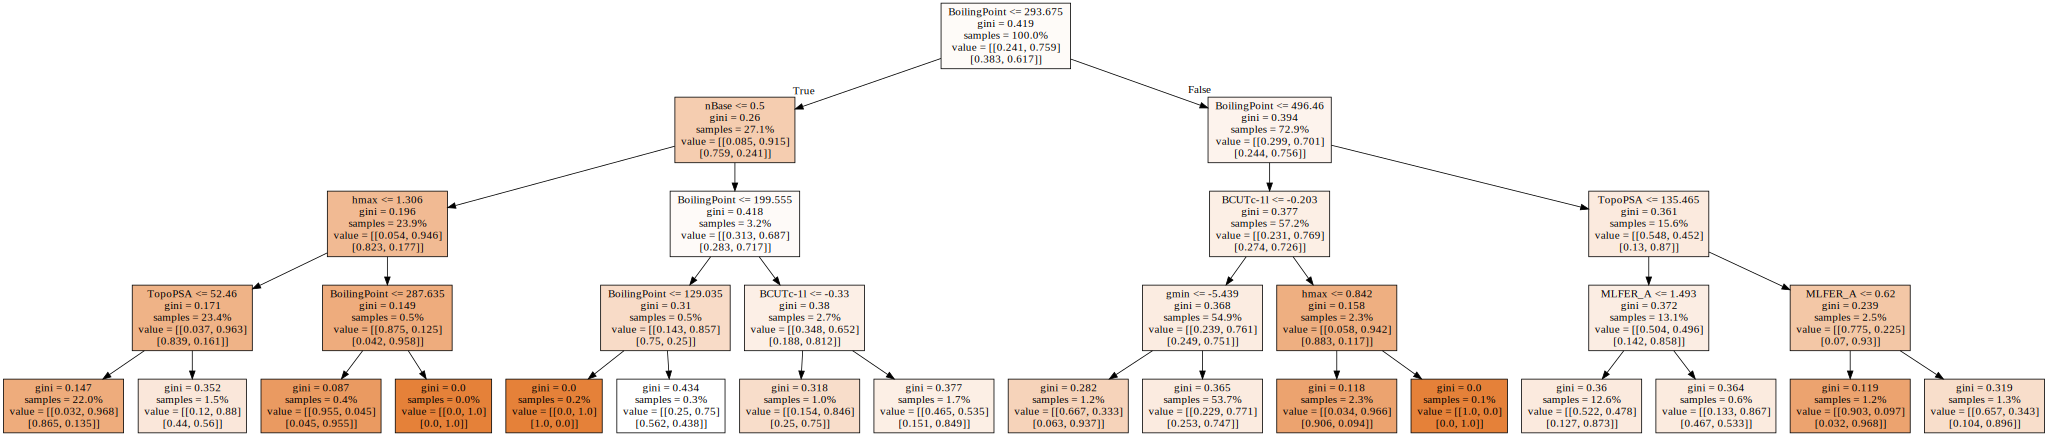

In [ ]:
# Export tree to DOT data
dot_data = export_graphviz(dtree, out_file=None,
                           feature_names=X_sel.columns,
                           class_names=['GC', 'LC'],
                           filled=True, proportion=True)

# Draw and save graph
graph = graphviz.Source(dot_data, format='PNG')
graph.render("decision_tree_graph")

graph

# Prediction

In [ ]:
path2 = 'http://users.uoa.gr/~nalygizakis/Applied%20Data%20Science/DescriptorsSusDat65000.xlsx'
for_prediction = pd.read_excel(path2)

In [ ]:
for_prediction.replace([np.inf, -np.inf], np.nan, inplace=True)

In [ ]:
for_prediction.dropna()

,Mol_Name,Name,SMILES,gmin,TopoPSA,BoilingPoint,BCUTc-1l,nN,nBase,MLFER_A,hmax,OK
0,NS00000001,Sulfaclozine,O=S(=O)(NC1=NC(Cl)=CN=C1)C2=CC=C(N)C=C2,-5.288090,105.29,446.69,-0.302532,4,0.0,0.606,1.351089,Okay
1,NS00000002,Sulfachloropyridazine,O=S(=O)(NC1=NN=C(Cl)C=C1)C2=CC=C(N)C=C2,-5.284635,105.29,485.02,-0.302514,4,0.0,0.606,1.348541,Okay
2,NS00000003,Sulfaguanidine,O=S(=O)(NC(=N)N)C1=CC=C(N)C=C1,-5.302418,130.44,410.20,-0.302561,4,3.0,0.783,1.270249,Okay
3,NS00000004,Sulfamerazine,O=S(=O)(NC1=NC=CC(=N1)C)C2=CC=C(N)C=C2,-5.328765,105.29,439.59,-0.302524,4,0.0,0.606,1.363025,Okay
4,NS00000005,Sulfamethizole,O=S(=O)(NC1=NN=C(S1)C)C2=CC=C(N)C=C2,-5.175221,130.59,471.67,-0.302510,4,0.0,0.606,1.309658,Okay
...,...,...,...,...,...,...,...,...,...,...,...,...
65686,NS00066792,2-methylbutyl hexanoate,O=C(OCC(C)CC)CCCCC,-0.033565,26.30,218.34,-0.315388,0,0.0,0.003,0.555903,Okay
65687,NS00066793,"(1-methyl-1,2-ethanediyl)bis[oxy(methyl-2,1-et...",O=C(OCC(OCC(OCC(OC(=O)C=C)C)C)C)C=C,-0.479067,71.06,309.97,-0.373722,0,0.0,0.003,0.749395,Okay
65688,NS00066794,2-bromobutyryl bromide,O=C(Br)C(Br)CC,0.160445,17.07,202.44,-0.276125,0,0.0,0.022,0.507935,Okay
65689,NS00066795,Oct-2-en-4-one,O=C(C=CC)CCCC,0.249398,17.07,170.18,-0.294387,0,0.0,0.003,0.474653,Okay


In [ ]:
for_prediction = for_prediction[for_prediction['BCUTc-1l'].notna()]
for_prediction = for_prediction[for_prediction['gmin'].notna()]
for_prediction = for_prediction[for_prediction['TopoPSA'].notna()]
for_prediction = for_prediction[for_prediction['BoilingPoint'].notna()]
for_prediction = for_prediction[for_prediction['nN'].notna()]
for_prediction = for_prediction[for_prediction['nBase'].notna()]
for_prediction = for_prediction[for_prediction['MLFER_A'].notna()]
for_prediction = for_prediction[for_prediction['hmax'].notna()]

In [ ]:
for_prediction

,Mol_Name,Name,SMILES,gmin,TopoPSA,BoilingPoint,BCUTc-1l,nN,nBase,MLFER_A,hmax,OK
0,NS00000001,Sulfaclozine,O=S(=O)(NC1=NC(Cl)=CN=C1)C2=CC=C(N)C=C2,-5.288090,105.29,446.69,-0.302532,4,0.0,0.606,1.351089,Okay
1,NS00000002,Sulfachloropyridazine,O=S(=O)(NC1=NN=C(Cl)C=C1)C2=CC=C(N)C=C2,-5.284635,105.29,485.02,-0.302514,4,0.0,0.606,1.348541,Okay
2,NS00000003,Sulfaguanidine,O=S(=O)(NC(=N)N)C1=CC=C(N)C=C1,-5.302418,130.44,410.20,-0.302561,4,3.0,0.783,1.270249,Okay
3,NS00000004,Sulfamerazine,O=S(=O)(NC1=NC=CC(=N1)C)C2=CC=C(N)C=C2,-5.328765,105.29,439.59,-0.302524,4,0.0,0.606,1.363025,Okay
4,NS00000005,Sulfamethizole,O=S(=O)(NC1=NN=C(S1)C)C2=CC=C(N)C=C2,-5.175221,130.59,471.67,-0.302510,4,0.0,0.606,1.309658,Okay
...,...,...,...,...,...,...,...,...,...,...,...,...
65686,NS00066792,2-methylbutyl hexanoate,O=C(OCC(C)CC)CCCCC,-0.033565,26.30,218.34,-0.315388,0,0.0,0.003,0.555903,Okay
65687,NS00066793,"(1-methyl-1,2-ethanediyl)bis[oxy(methyl-2,1-et...",O=C(OCC(OCC(OCC(OC(=O)C=C)C)C)C)C=C,-0.479067,71.06,309.97,-0.373722,0,0.0,0.003,0.749395,Okay
65688,NS00066794,2-bromobutyryl bromide,O=C(Br)C(Br)CC,0.160445,17.07,202.44,-0.276125,0,0.0,0.022,0.507935,Okay
65689,NS00066795,Oct-2-en-4-one,O=C(C=CC)CCCC,0.249398,17.07,170.18,-0.294387,0,0.0,0.003,0.474653,Okay


In [ ]:
NORMAN_ID=for_prediction['Mol_Name']
Name=for_prediction['Name']
SMILES=for_prediction['SMILES']

In [ ]:
sel_feat = ['gmin', 'TopoPSA', 'BoilingPoint', 'BCUTc-1l', 'nN', 'nBase', 'MLFER_A', 'hmax']
for_prediction = for_prediction[sel_feat]

for_prediction.head()

,gmin,TopoPSA,BoilingPoint,BCUTc-1l,nN,nBase,MLFER_A,hmax
0,-5.288090,105.29,446.69,-0.302532,4,0.0,0.606,1.351089
1,-5.284635,105.29,485.02,-0.302514,4,0.0,0.606,1.348541
2,-5.302418,130.44,410.20,-0.302561,4,3.0,0.783,1.270249
3,-5.328765,105.29,439.59,-0.302524,4,0.0,0.606,1.363025
4,-5.175221,130.59,471.67,-0.302510,4,0.0,0.606,1.309658


In [ ]:
for_prediction

,gmin,TopoPSA,BoilingPoint,BCUTc-1l,nN,nBase,MLFER_A,hmax
0,-5.288090,105.29,446.69,-0.302532,4,0.0,0.606,1.351089
1,-5.284635,105.29,485.02,-0.302514,4,0.0,0.606,1.348541
2,-5.302418,130.44,410.20,-0.302561,4,3.0,0.783,1.270249
3,-5.328765,105.29,439.59,-0.302524,4,0.0,0.606,1.363025
4,-5.175221,130.59,471.67,-0.302510,4,0.0,0.606,1.309658
...,...,...,...,...,...,...,...,...
65686,-0.033565,26.30,218.34,-0.315388,0,0.0,0.003,0.555903
65687,-0.479067,71.06,309.97,-0.373722,0,0.0,0.003,0.749395
65688,0.160445,17.07,202.44,-0.276125,0,0.0,0.022,0.507935
65689,0.249398,17.07,170.18,-0.294387,0,0.0,0.003,0.474653


In [ ]:
# Predict on test set
results_for_prediction = dtree.predict_proba(for_prediction)
results_for_prediction

[array([[0.22890257, 0.77109743],
        [0.22890257, 0.77109743],
        [0.22890257, 0.77109743],
        ...,
        [0.03185841, 0.96814159],
        [0.03185841, 0.96814159],
        [0.03185841, 0.96814159]]), array([[0.25280695, 0.74719305],
        [0.25280695, 0.74719305],
        [0.25280695, 0.74719305],
        ...,
        [0.86548673, 0.13451327],
        [0.86548673, 0.13451327],
        [0.86548673, 0.13451327]])]

In [ ]:
# Predict on test set
results_for_prediction_b = dtree.predict(for_prediction)
results_for_prediction_b

array([[1, 1],
       [1, 1],
       [1, 1],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]])

In [ ]:
a_file = open("test.txt", "w")
for row in results_for_prediction:
    np.savetxt(a_file, row)

In [ ]:
Name.to_csv("name.csv")
SMILES.to_csv("SMILES.csv")
NORMAN_ID.to_csv("NORMAN_ID.csv")